In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

# customized keras_preprocessing.image in preprocess_image.py
# u_net in the network.py
# mean_iou metric in metrics.py
# predict_mask in utils.py

from lib import *

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
import sys
import random

In [4]:
import warnings
# block tensorflow~numpy warnings
warnings.filterwarnings('ignore')

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Environment

In [5]:
BATCH_SIZE = 10 
# memory issues on 8 gig memory container
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train'
TRAIN_MASK_PATH = 'data/train_mask'

VALIDATE_PATH = 'data/valid'
VALIDATE_MASK_PATH = 'data/valid_mask'

TEST_PATH = 'data/test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 83

images = os.listdir(TRAIN_PATH)
val_images = os.listdir(VALIDATE_PATH)
test_images = os.listdir(TEST_PATH)


# Данные

Посмотрим на данные:

In [6]:
# get_xy reshapes the images to 240 * 240 

X_train, Y_train = get_xy(images, TRAIN_PATH, TRAIN_MASK_PATH)
X_validate, Y_validate = get_xy(val_images, VALIDATE_PATH, VALIDATE_MASK_PATH)
X_test, Y_test_placeholder = get_xy(test_images, TEST_PATH)

In [7]:
random_index = np.random.choice(X_train.shape[0])

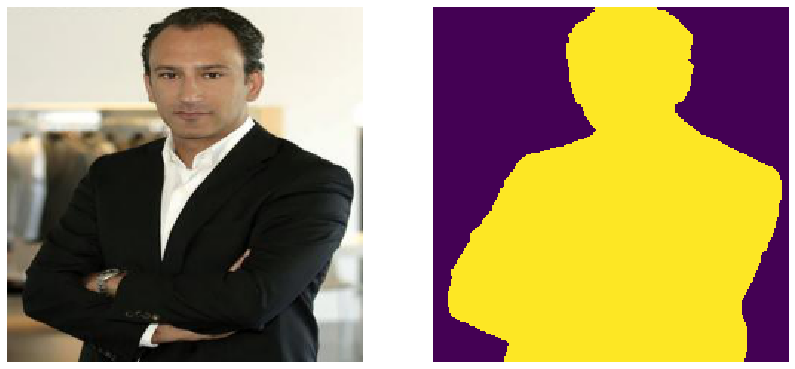

In [8]:
show_img_with_mask(X_train[random_index], Y_train[random_index][:,:,0])

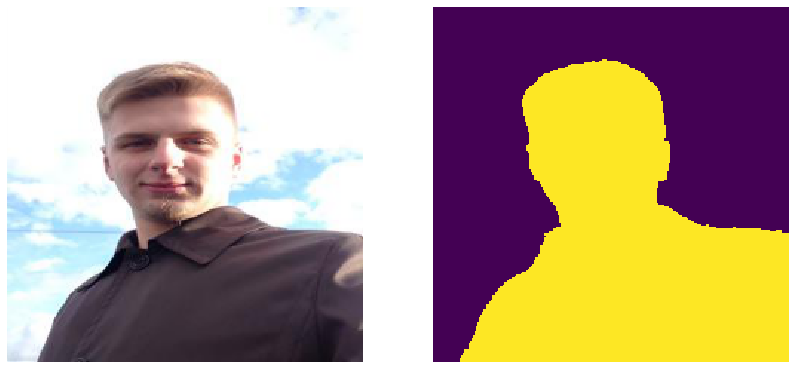

In [9]:
random_index = np.random.choice(X_validate.shape[0])
show_img_with_mask(X_validate[random_index], Y_validate[random_index][:,:,0])

# Preprocessing

## data augmentation

In [10]:
# apply shear, rotation, zoom, shift, fillcontrast and contrast_stretching to augment train

image_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)
mask_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)



In [11]:
# augment valiadation images 
image_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)
mask_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)

image_datagen.fit(X_validate, augment=True, seed=seed)
mask_datagen.fit(Y_validate, augment=True, seed=seed)

x_val=image_datagen.flow(X_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen.flow(Y_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

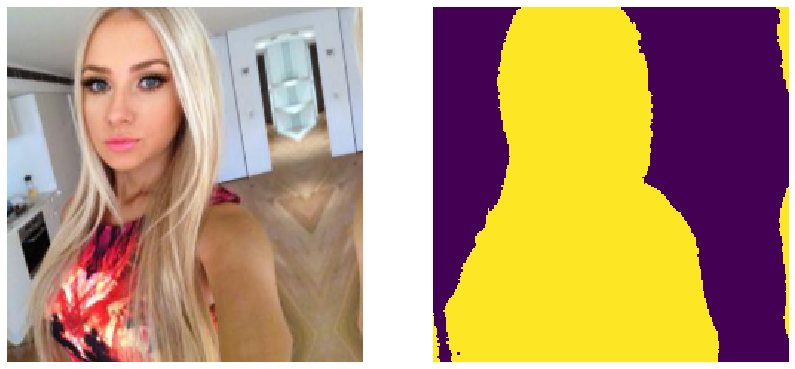

In [12]:
show_img_with_mask(x.next()[0].astype(np.uint8), np.squeeze(y.next()[0].astype(np.uint8)))

In [13]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

## compile u-net

In [14]:
model = u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 

## train u-net

In [15]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-segmentation-3.3.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1696s 7s/step - loss: 0.5876 - mean_iou: 0.3472 - val_loss: 0.6095 - val_mean_iou: 0.4025

Epoch 00001: val_loss improved from inf to 0.60955, saving model to model-segmentation-3.3.h5
Epoch 2/15
250/250 [==============================] - 1452s 6s/step - loss: 0.5087 - mean_iou: 0.4250 - val_loss: 0.5173 - val_mean_iou: 0.4428

Epoch 00002: val_loss improved from 0.60955 to 0.51729, saving model to model-segmentation-3.3.h5
Epoch 3/15
250/250 [==============================] - 1457s 6s/step - loss: 0.4841 - mean_iou: 0.4559 - val_loss: 0.4729 - val_mean_iou: 0.4662

Epoch 00003: val_loss improved from 0.51729 to 0.47291, saving model to model-segmentation-3.3.h5
Epoch 4/15
250/250 [==============================] - 1383s 6s/step - loss: 0.4540 - mean_iou: 0.4758 - val_loss: 0.4253 - val_mean_iou: 0.4845

Epoch 00004: val_loss improved from 0.47291 to 0.42530, saving model to model-segmentation-3.3.h5
Epoch 5/15
250/250 [============

In [16]:
checkpointer = ModelCheckpoint('model-segmentation-3.3.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=5, callbacks=[earlystopper, checkpointer])

Epoch 1/5
250/250 [==============================] - 1316s 5s/step - loss: 0.3016 - mean_iou: 0.6044 - val_loss: 0.8778 - val_mean_iou: 0.6078

Epoch 00001: val_loss improved from inf to 0.87778, saving model to model-segmentation-3.3.h5
Epoch 2/5
250/250 [==============================] - 1311s 5s/step - loss: 0.2581 - mean_iou: 0.6113 - val_loss: 0.3220 - val_mean_iou: 0.6148

Epoch 00002: val_loss improved from 0.87778 to 0.32202, saving model to model-segmentation-3.3.h5
Epoch 3/5
250/250 [==============================] - 1320s 5s/step - loss: 0.2478 - mean_iou: 0.6183 - val_loss: 0.2332 - val_mean_iou: 0.6218

Epoch 00003: val_loss improved from 0.32202 to 0.23317, saving model to model-segmentation-3.3.h5
Epoch 4/5
250/250 [==============================] - 1305s 5s/step - loss: 0.2399 - mean_iou: 0.6253 - val_loss: 0.2442 - val_mean_iou: 0.6286

Epoch 00004: val_loss did not improve from 0.23317
Epoch 5/5
250/250 [==============================] - 1305s 5s/step - loss: 0.2223 -

In [17]:
checkpointer = ModelCheckpoint('model-segmentation-3.3.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1319s 5s/step - loss: 0.2715 - mean_iou: 0.6370 - val_loss: 1.2348 - val_mean_iou: 0.6397

Epoch 00001: val_loss improved from inf to 1.23478, saving model to model-segmentation-3.3.h5
Epoch 2/15
250/250 [==============================] - 1313s 5s/step - loss: 0.2254 - mean_iou: 0.6424 - val_loss: 0.3853 - val_mean_iou: 0.6451

Epoch 00002: val_loss improved from 1.23478 to 0.38530, saving model to model-segmentation-3.3.h5
Epoch 3/15
250/250 [==============================] - 1302s 5s/step - loss: 0.2171 - mean_iou: 0.6479 - val_loss: 0.2268 - val_mean_iou: 0.6506

Epoch 00003: val_loss improved from 0.38530 to 0.22678, saving model to model-segmentation-3.3.h5
Epoch 4/15
250/250 [==============================] - 1317s 5s/step - loss: 0.2154 - mean_iou: 0.6532 - val_loss: 0.2191 - val_mean_iou: 0.6556

Epoch 00004: val_loss improved from 0.22678 to 0.21910, saving model to model-segmentation-3.3.h5
Epoch 5/15
250/250 [============

In [18]:
checkpointer = ModelCheckpoint('model-segmentation-3.3.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1306s 5s/step - loss: 0.2391 - mean_iou: 0.6831 - val_loss: 1.0796 - val_mean_iou: 0.6847

Epoch 00001: val_loss improved from inf to 1.07961, saving model to model-segmentation-3.3.h5
Epoch 2/15
250/250 [==============================] - 1335s 5s/step - loss: 0.1895 - mean_iou: 0.6864 - val_loss: 0.3328 - val_mean_iou: 0.6882

Epoch 00002: val_loss improved from 1.07961 to 0.33279, saving model to model-segmentation-3.3.h5
Epoch 3/15
250/250 [==============================] - 1319s 5s/step - loss: 0.1842 - mean_iou: 0.6900 - val_loss: 0.2064 - val_mean_iou: 0.6918

Epoch 00003: val_loss improved from 0.33279 to 0.20638, saving model to model-segmentation-3.3.h5
Epoch 4/15
250/250 [==============================] - 1317s 5s/step - loss: 0.1782 - mean_iou: 0.6935 - val_loss: 0.2037 - val_mean_iou: 0.6954

Epoch 00004: val_loss improved from 0.20638 to 0.20374, saving model to model-segmentation-3.3.h5
Epoch 5/15
250/250 [============

In [ ]:
checkpointer = ModelCheckpoint('model-segmentation-3.3.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1746s 7s/step - loss: 0.2179 - mean_iou: 0.7087 - val_loss: 1.2903 - val_mean_iou: 0.7099

Epoch 00001: val_loss improved from inf to 1.29026, saving model to model-segmentation-3.3.h5
Epoch 2/15
250/250 [==============================] - 1406s 6s/step - loss: 0.1711 - mean_iou: 0.7111 - val_loss: 0.2361 - val_mean_iou: 0.7125

Epoch 00002: val_loss improved from 1.29026 to 0.23613, saving model to model-segmentation-3.3.h5
Epoch 3/15
250/250 [==============================] - 1714s 7s/step - loss: 0.1707 - mean_iou: 0.7139 - val_loss: 0.1797 - val_mean_iou: 0.7152

Epoch 00003: val_loss improved from 0.23613 to 0.17969, saving model to model-segmentation-3.3.h5
Epoch 4/15
110/250 [============>.................] - ETA: 13:24 - loss: 0.1694 - mean_iou: 0.7158